# Langmuir isotherm predictions improved by FoKL-GPy in benchmark comparison

---

## Abstract

The Langmuir isotherm adsorption model relies on a linear line of best-fit to interpret experimental results. However, replacing this linear fit with a Gaussian process (GP) model was shown to decrease the error of predictions by about half. For this benchmark comparison, data was taken from a mica experiment conducted by Irving Langmuir (1918).[$^{[1]}$](#1) The experiment selected was conducted at a constant temperature to simplify training of the GP model; though, with validation of this method completed, including data from multiple temperatures will enable the site-fraction of a Langmuir isotherm to be expressed symbolically at any temperature and pressure pair using FoKL-GPy's[$^{[2,3]}$](#2) ability to embed GP's in Pyomo.[$^{[4,5]}$](#4)

---

## Contents

- [Background](#background)
- [The Case for FoKL-GPy](#the-case-for-fokl-gpy)
- [Outline of Method](#outline-of-method)
- [Implementation of Method](#implementation-of-method)
- [Conclusion](#conclusion)
- [References](#references)

---

## Background

The Langmuir isotherm is
$\theta_1 = \frac{q}{q_{max}} = \frac{\sigma_1 \mu}{1 + \sigma_1 \mu}$
where
$\mu = \frac{m}{M} = \frac{p}{\sqrt{2 \pi M R T}}$.

Rearranging,
$q = \frac{\sigma_1 q_{max} \mu}{1 + \sigma_1 \mu}$.

For varying pressure $p$ at constant temperature $T$, it is typically assumed that $\sigma_1$ is constant such that
$\sigma_1 \mu = a p$.

This assumption, together with $b \equiv q_{max}$, enable
$\frac{p}{q} = \frac{1}{b}p + \frac{1}{ab}$
which is just $y=mx+b$ such that a linear fit of measurements $q(p)$ provides constant values $a$ and $b$ at constant $T$.

---

## The Case for FoKL-GPy

Examining more closely reveals
$\sigma_1 \mu = \sigma_1 \frac{p}{\sqrt{2 \pi M R T}} \implies a = \frac{\sigma_1}{\sqrt{2 \pi M R T}}$.

Unless reaction rates $\alpha$ and $\nu_1$ are constant with respect to pressure, since $\sigma_1 = \frac{\alpha}{\nu_1}$, the typical assumption that $a$ is constant at $T$ may be improved with the modeling of a Gaussian process (GP). In other words, at constant $T$, assuming $a$ is constant is equivalent to assuming $\sigma_1$ is constant.

Examining the reaction rates as expressed in the relative life,
$\sigma_1 = \frac{\alpha}{\nu_1} = \frac{\exp(\Delta_f G / RT)}{\exp(\Delta_r G / RT)} = \exp(\frac{\Delta_f G - \Delta_r G}{RT})$.

Since Gibbs free energy $G$ is not independent of $p$, and therefore $\sigma_1$ is not constant at constant $T$, $\sigma_1$ may be more accurately modeled with a GP rather than linear fit. Furthermore, since a FoKL-GPy model may be embedded in Pyomo, additional chemistry constraints and an optimization objective may be included, though this is also possible with a linear Langmuir isotherm model.

---

## Outline of Method

As an initial benchmark comparison to validate the use of a GP in modeling a Langmuir isotherm, Table XI from Langmuir's mica experiment will provide a dataset. The data contains measurements of $(q, p)$ at constant $T$ with a linear fit of $\frac{p}{q}$ vs. $p$. It is expected for FoKL-GPy to minimize the error.

From the data, $\ln(\sigma_1)$ will be calculated for FoKL-GPy to train on. This will be termed $\Delta$. The value of $q_{max}$ will be set as $b$ found from the linear fit. As this value simply scales $q_{cal}$, it is not expected to make a difference in the comparison since both models are scaling $q_{cal}$ together. Note the use of $\Delta \equiv \ln(\sigma_1)$ is to ensure $\sigma_1$ is positive.

To calculate $\sigma_1$, recall $q = \frac{\sigma_1 q_{max} \mu}{1 + \sigma_1 \mu}$. This yields $\sigma_1 = \frac{q}{\mu(q_{max}-q)}$. So, if $q_{max}$ is known, then $\sigma_1$ may be solved for since $q$ is measured and $\mu$ is a known function of $(T, p)$. If it is assumed that $q_{max}$ is independent of $T$, which is reasonable since the driving force of the surface characteristics should be $T$ and not the gas's $p$, then with this dataset being at constant $T$, $q_{max}=b$ should suffice. Otherwise, for datasets at multiple $T$, $q_{max}$ must be modeled or measured in some way.

With regard to $q_{max}$, the place to improve would be to measure or model $q_{max}$ in perhaps a more direct or accurate way. Measurements of $q$ after a long time, i.e., $\frac{\partial}{\partial t}(q) \approx 0$, could also provide values of $q_{max}$.

With the $\Delta$ FoKL-GPy model, $\theta_1$ may be predicted at any $p$. Scaling $\theta_1$ by $q_{max}=b$ will enable a direct comparison with Langmuir's $q_{cal}$. The percent errors of the linear and GP predictions vs. the measurements may then be compared to validate this method.

---

## Implementation of Method

Data from Langmuir's mica experiment, Table XI, has been written to *data/TABLE_XI.txt*. The data is as follows.

| T (K)           | p (bars)        | qobs (mm^3)     | a (1/bars)      | b (mm^3)        | qcal (mm^3)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
| 155             | 172.0           | 55.0            | 0.085           | 57.3            | 53.6            |
| 155             | 98.0            | 49.9            | 0.085           | 57.3            | 51.1            |
| 155             | 41.4            | 44.6            | 0.085           | 57.3            | 44.6            |
| 155             | 20.6            | 35.2            | 0.085           | 57.3            | 36.4            |
| 155             | 11.9            | 26.9            | 0.085           | 57.3            | 28.8            |
| 155             | 7.3             | 21.1            | 0.085           | 57.3            | 22.0            |
| 155             | 4.8             | 16.9            | 0.085           | 57.3            | 16.6            |
| 155             | 3.19            | 13.8            | 0.085           | 57.3            | 12.2            |
| 155             | 2.06            | 9.2             | 0.085           | 57.3            | 8.6             |
| 155             | 1.60            | 6.2             | 0.085           | 57.3            | 6.9             |

---

Importing modules and defining constants:

In [10]:
import os
import sys
sys.path.append(os.path.join('..', '..', '..'))  # include local path (i.e., this package)
from src.FoKL import FoKLRoutines
# from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate


SI_scale = True
logscale = True
save = False

M = 0.0280134  # molecular weight, kg / mol
if SI_scale is True:
    R = 8.31446261815324  # universal gas constant, J / (K * mol)
else:
    R = 8314462.61815324  # universal gas constant, mN mm / (K * mol)

Loading the data:

In [11]:
data = np.loadtxt(os.path.join('data2', 'TABLE_XI.txt'), skiprows=1)

Parsing the data and converting units:

In [12]:
T = data[:, 0][0]  # K, scalar
p_bars = data[:, 1]  # bars
q_mm3 = data[:, 2]  # mm^3
a_inv_bars = data[:, 3][0]  # 1/bars, scalar
qmax_mm3 = data[:, 4][0]  # mm^3, =b, scalar
qcal_mm3 = data[:, 5]  # mm^3, for benchmark comparison

# Convert units is requested:
if SI_scale is True:
    p = p_bars * 1e5  # bars to Pa
    q = q_mm3 * 1e-9  # mm^3 to m^3
    a = a_inv_bars * 1e-5  # 1/bars to 1/Pa
    qmax = qmax_mm3 * 1e-9  # mm^3 to m^3
    qcal = qcal_mm3 * 1e-9  # mm^3 to m^3
else:
    p = p_bars  # bars to Pa
    q = q_mm3  # mm^3 to m^3
    a = a_inv_bars  # 1/bars to 1/Pa
    qmax = qmax_mm3  # mm^3 to m^3
    qcal = qcal_mm3  # mm^3 to m^3

Calculating $mu$ and $sigma_1$:

In [13]:
mu = p / np.sqrt(2 * np.pi * M * R * T)
sigma1 = q / mu / (qmax - q)

Initializing FoKL-GPy model with continuous basis functions, i.e., ```kernel=1```:

In [14]:
model = FoKLRoutines.FoKL(kernel=1)

Train FoKL-GPy model on $\Delta \propto \ln(p)$:

In [15]:
Delta = np.log(sigma1)
ln_p = np.log(p)
_ = model.fit(ln_p, Delta, clean=True)

[1, -21.89648705948277]
[2, -22.228996132349916]
[3, -27.373232919441662]
[4, -27.373232919441662]
[5, -39.43870656923165]
[6, -42.86728322822478]
[7, -42.86728322822478]
[8, -42.86728322822478]
[9, -43.69463144502558]
[10, -46.69449525104374]
[11, -46.69449525104374]
[12, -46.69449525104374]
[13, -52.840445532032575]
[14, -53.58649581836379]
[15, -549.3401975318338]
[16, -549.3401975318338]
[17, -549.3401975318338]
[18, -549.3401975318338]


Plot curve fits (linear vs. GP):

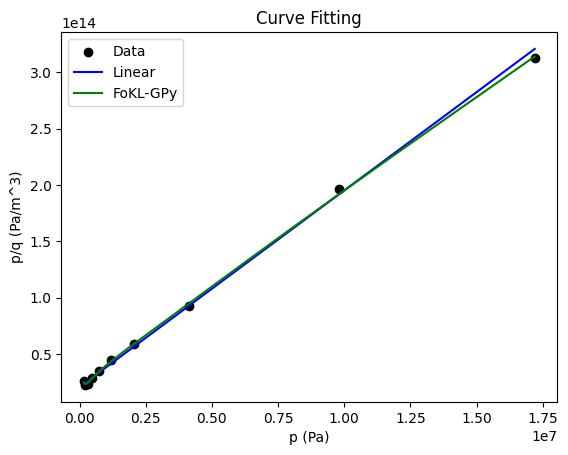

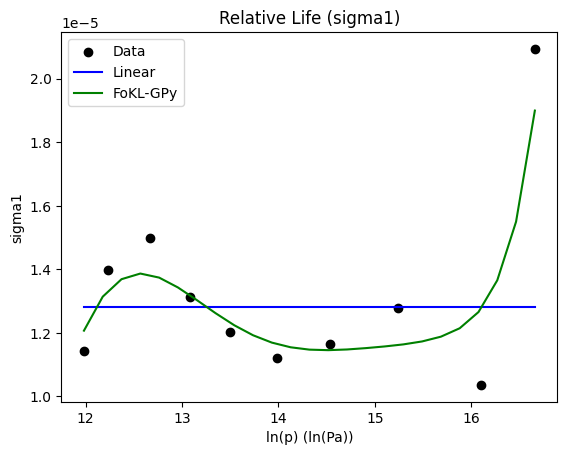

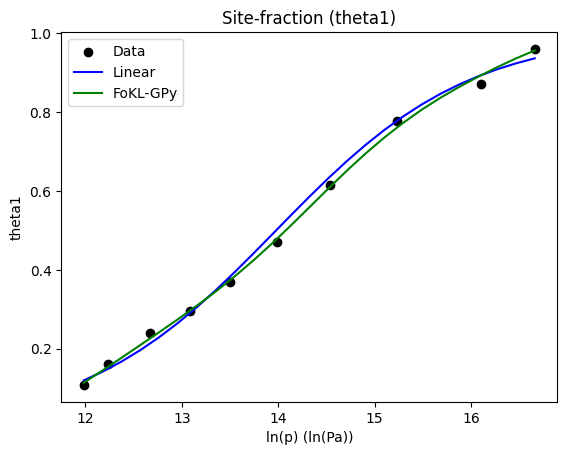

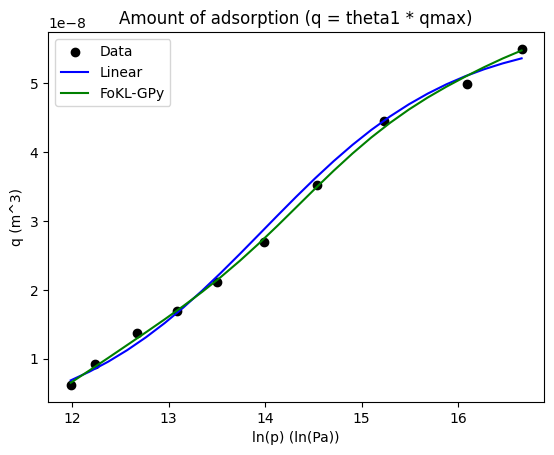

In [16]:
res = 25

if SI_scale is True:
    plt_xlabel = 'p (Pa)'
    plt_ylabel1 = 'p/q (Pa/m^3)'
    plt_ylabel5 = 'q (m^3)'
else:
    plt_xlabel = 'p (bars)'
    plt_ylabel1 = 'p/q (bars/mm^3)'
    plt_ylabel5 = 'q (mm^3)'

# Plot p/q vs. p:

inputs_fokl = np.linspace(model.inputs[0, 0], model.inputs[-1, 0], res)[:, np.newaxis]  # increase resolution of FoKL inputs
Delta_fokl = model.evaluate(inputs_fokl)  # = np.log(sigma1_fokl)
sigma1_fokl = np.exp(Delta_fokl)
p_fokl = np.squeeze(np.exp(inputs_fokl * (model.normalize[0][1] - model.normalize[0][0]) + model.normalize[0][0]))  # denormalize, then exp()
mu_fokl = p_fokl / np.sqrt(2 * np.pi * M * R * T)
q_fokl= sigma1_fokl * qmax * mu_fokl / (1 + sigma1_fokl * mu_fokl)

p_linear = np.linspace(p[0], p[-1], 2)

plt.figure()
plt.scatter(p, p / q, color='k')  # experimental measurements
plt.plot(p_linear, p_linear / qmax + 1 / (a * qmax), color='b')  # linear fit (from Langmuir, mx+b --> p/b + 1/(ab))
plt.plot(p_fokl, p_fokl / q_fokl, color='g')  # FoKL-GPy

plt.title("Curve Fitting")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel1)
plt.legend(['Data', 'Linear', 'FoKL-GPy'])

# ---------------------------

if logscale is True:
    plt_p, plt_p_linear, plt_p_fokl = ln_p, np.log(p_linear), np.log(p_fokl)
    if SI_scale is True:
        plt_xlabel = 'ln(p) (ln(Pa))'
    else:
        plt_xlabel = 'ln(p) (ln(bars))'
else:
    plt_p, plt_p_linear, plt_p_fokl = p, p_linear, p_fokl

# Plot sigma vs. p:

    #   q = a b p / (1 + a p)
        #   q + q a p = a b p
        #   a (b p - q p) = q
        #   a = q / (p * (b - q))
        #   sigma = (q / (p * (b - q))) sqrt(2 pi M R T)
        #   sigma = q sqrt(2 pi M R T) / (p * (b - q))  # experimental measurements, assuming b=qmax is known
    #   a p = sigma mu
        #   sigma = a p / mu = a sqrt(2 pi M R T)  # linear

# sigma1 = q * np.sqrt(2 * np.pi * M * R * T) / (p * (qmax - q))  # already calculated, sigma1 = q / mu / (qmax - q)
sigma1_linear = a * np.sqrt(2 * np.pi * M * R * T)

plt.figure()
plt.scatter(plt_p, sigma1, color='k')  # experimental measurements
plt.plot(plt_p_linear, [sigma1_linear, sigma1_linear], color='b')  # linear fit (constant value)
plt.plot(plt_p_fokl, sigma1_fokl, color='g')  # FoKL-GPy

plt.title("Relative Life (sigma1)")
plt.xlabel(plt_xlabel)
plt.ylabel("sigma1")
plt.legend(['Data', 'Linear', 'FoKL-GPy'])

# ---------------------------

# # Plot ln(sigma1) vs. p (i.e., validation test):

# # Delta = np.log(sigma1)  # already calculated
# Delta_linear = np.log(sigma1_linear)

# plt.figure()
# plt.scatter(plt_p, Delta, color='k')  # experimental measurements
# plt.plot(plt_p_linear, [Delta_linear, Delta_linear], color='b')  # linear fit (constant value)
# plt.plot(plt_p_fokl, Delta_fokl, color='g')  # FoKL-GPy

# plt.title("GP Model (Delta)")
# plt.xlabel(plt_xlabel)
# plt.ylabel("Delta")
# plt.legend(['Data', 'Linear', 'FoKL-GPy'])

# -----------------------------

# Plot of site-fraction:

theta1 = sigma1 * mu / (1 + sigma1 * mu)
theta1_linear = sigma1_linear * mu_fokl / (1 + sigma1_linear * mu_fokl)  # mu_fokl is just high resolution
theta1_fokl = sigma1_fokl * mu_fokl / (1 + sigma1_fokl * mu_fokl)

plt.figure()
plt.scatter(plt_p, theta1, color='k')  # experimental measurements
plt.plot(plt_p_fokl, theta1_linear, color='b')  # linear fit; plt_p_fokl is just high resolution
plt.plot(plt_p_fokl, theta1_fokl, color='g')  # FoKL-GPy

plt.title("Site-fraction (theta1)")
plt.xlabel(plt_xlabel)
plt.ylabel("theta1")
plt.legend(['Data', 'Linear', 'FoKL-GPy'])

# --------------------------------

# Plot of q:

plt.figure()
plt.scatter(plt_p, q, color='k')  # experimental measurements
plt.plot(plt_p_fokl, theta1_linear * qmax, color='b')  # linear fit; plt_p_fokl is just high resolution
plt.plot(plt_p_fokl, theta1_fokl * qmax, color='g')  # FoKL-GPy

plt.title("Amount of adsorption (q = theta1 * qmax)")
plt.xlabel(plt_xlabel)
plt.ylabel(plt_ylabel5)
plt.legend(['Data', 'Linear', 'FoKL-GPy'])

Make table of results (i.e., benchmark comparison):

In [17]:
results_Delta = model.evaluate()
results_sigma1 = np.exp(results_Delta)
results_theta1 = results_sigma1 * mu / (1 + results_sigma1 * mu)
results_qcal = results_theta1 * qmax
if SI_scale is True:
    results_qcal_mm3 = results_qcal * 1e9  # m^3 to mm^3
else:
    results_qcal_mm3 = results_qcal  # already mm^3

# Calculate error in mm^3
error_linear = qcal_mm3 - q_mm3
error_fokl = results_qcal_mm3 - q_mm3

results_data = np.concatenate([np.round(error_linear[:, np.newaxis], 1), results_qcal_mm3[:, np.newaxis], np.round(error_fokl[:, np.newaxis], 1)], axis=1)  # save FoKL-GPy results
if save is True:
    np.savetxt(os.path.join('data', 'benchmark_comparison.txt'), results_data, delimiter='\t\t\t', fmt='%.1f')  # then, manually add column headers and adjust tab spacing

For a better comparison, converting error to percent error then finding mean and standard deviation:

In [18]:
error_linear_percent = error_linear / q_mm3 * 100
error_fokl_percent = error_fokl / q_mm3 * 100

error_linear_percent_std = np.std(error_linear_percent)
error_fokl_percent_std = np.std(error_fokl_percent)

error_linear_percent_absmean = np.mean(np.abs(error_linear_percent))
error_fokl_percent_absmean = np.mean(np.abs(error_fokl_percent))

# Print as tables:

table1 = [['Percent Error (Linear)', 'Percent Error (GP)']] + list([np.round(error_linear_percent[i], 2), np.round(error_fokl_percent[i], 2)] for i in range(10))
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

table2 = [['Std. Dev. (Linear)', 'Std. Dev. (GP)'], [np.round(error_linear_percent_std, 2), np.round(error_fokl_percent_std, 2)]]
print(tabulate(table2, headers='firstrow', tablefmt='fancy_grid'))

table3 = [['Mean of Absolute Values (Linear)', 'Mean of Absolute Values (GP)'], [np.round(error_linear_percent_absmean, 2), np.round(error_fokl_percent_absmean, 2)]]
print(tabulate(table3, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════════╤══════════════════════╕
│   Percent Error (Linear) │   Percent Error (GP) │
╞══════════════════════════╪══════════════════════╡
│                    -2.55 │                -0.41 │
├──────────────────────────┼──────────────────────┤
│                     2.4  │                 2.47 │
├──────────────────────────┼──────────────────────┤
│                     0    │                -2.16 │
├──────────────────────────┼──────────────────────┤
│                     3.41 │                -0.62 │
├──────────────────────────┼──────────────────────┤
│                     7.06 │                 2.07 │
├──────────────────────────┼──────────────────────┤
│                     4.27 │                 1.52 │
├──────────────────────────┼──────────────────────┤
│                    -1.78 │                 0.32 │
├──────────────────────────┼──────────────────────┤
│                   -11.59 │                -5.93 │
├──────────────────────────┼──────────────────────┤
│           

## Conclusion

The percent errors from the GP model predictions, overall, are about half that of the linear fit predictions. The standard deviation of the error improved from $6.29\%$ to $3.06\%$; and, the average of the errors' absolute values improved from $5.09\%$ to $2.44\%$.

## References

<c id=1> [1] <c/> [THE ADSORPTION OF GASES ON PLANE SURFACES OF GLASS, MICA AND PLATINUM. <br>
&emsp;&nbsp; Irving Langmuir <br>
&emsp;&nbsp; Journal of the American Chemical Society 1918 40 (9), 1361-1403 <br>
&emsp;&nbsp; DOI: 10.1021/ja02242a004](https://pubs.acs.org/doi/epdf/10.1021/ja02242a004#) <br>

<c id=1> [2] <c/> [K. Hayes, M.W. Fouts, A. Baheri and D.S. Mebane, "Forward variable selection enables fast and accurate dynamic system identification with Karhunen-Loève decomposed Gaussian processes", arXiv:2205.13676](https://arxiv.org/abs/2205.13676)

<c id=1> [3] <c/> [FoKL-GPy. GitHub. Retrieved from https://github.com/ESMS-Group-Public/FoKL-GPy.](https://github.com/ESMS-Group-Public/FoKL-GPy)

<c id=1> [4] <c/> [Bynum, Michael L., Gabriel A. Hackebeil, William E. Hart, Carl D. Laird, Bethany L. Nicholson, John D. Siirola, Jean-Paul Watson, and David L. Woodruff. Pyomo - Optimization Modeling in Python. Third Edition Vol. 67. Springer, 2021.](https://link.springer.com/book/10.1007/978-3-030-68928-5)

<c id=1> [5] <c/> Hart, William E., Jean-Paul Watson, and David L. Woodruff. "Pyomo: modeling and solving mathematical programs in Python." Mathematical Programming Computation 3(3) (2011): 219-260.

---

Last update: May 19, 2024